In [1]:
# clone files of yolo from github
!git clone https://github.com/allanzelener/yad2k.git
!cd yad2k

fatal: destination path 'yad2k' already exists and is not an empty directory.


In [2]:
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import scipy.io
import scipy.misc
import numpy as np
import pandas as pd
import PIL
from PIL import ImageFont, ImageDraw, Image
import tensorflow as tf

from tensorflow.python.framework.ops import EagerTensor
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input

# import some prebuild functions from yolo
from yad2k.yad2k.models.keras_yolo import yolo_head
from yad2k.yad2k.utils.draw_boxes import draw_boxes, get_colors_for_classes
from yad2k.yad2k.utils.yolo_utils import read_classes, read_anchors, preprocess_image

%matplotlib inline

In [3]:
class_names = read_classes("model_data/coco_classes.txt")
anchors = read_anchors("model_data/yolo_anchors.txt")

In [4]:
# predefined anchor sizes as prior 
anchors

array([[0.57273 , 0.677385],
       [1.87446 , 2.06253 ],
       [3.33843 , 5.47434 ],
       [7.88282 , 3.52778 ],
       [9.77052 , 9.16828 ]])

In [5]:
yolo_model = load_model("model_data/", compile=False)

/Users/apple/opt/anaconda3/lib/python3.8/site-packages/keras/layers/core/lambda_layer.py:297: UserWarning: yad2k.models.keras_yolo is not loaded, but a Lambda layer uses it. It may cause errors.
  function = cls._parse_function_from_config(config, custom_objects,


In [6]:
yolo_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 608, 608, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 608, 608, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 608, 608, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                      

In [7]:
yolo_model.output

<KerasTensor: shape=(None, 19, 19, 425) dtype=float32 (created by layer 'conv2d_22')>

The model outputs a total of 19x19x5x85 numbers, with each box described by 85 numbers. The (19,19,425) dimensional tensor can be rearrange into the following variables:  
- `box_confidence`: tensor of shape $(19, 19, 5, 1)$ containing $p_c$ (confidence probability that there's some object) for each of the 5 boxes predicted in each of the 19x19 cells.
- `boxes`: tensor of shape $(19, 19, 5, 4)$ containing the midpoint and dimensions $(b_x, b_y, b_h, b_w)$ for each of the 5 boxes in each cell.
- `box_class_probs`: tensor of shape $(19, 19, 5, 80)$ containing the "class probabilities" $(c_1, c_2, ... c_{80})$ for each of the 80 classes for each of the 5 boxes per cell.

Generally speaking, YOLO has two steps of filtering. The function below `yolo_filter_boxes` filters YOLO boxes by thresholding on box scores.

In [8]:
def yolo_filter_boxes(boxes, box_confidence, box_class_probs, threshold = .6):
    """Filters YOLO boxes by thresholding on object scores.
    
    Arguments:
        boxes -- tensor of shape (19, 19, 5, 4),
        box_confidence -- tensor of shape (19, 19, 5, 1)
        box_class_probs -- tensor of shape (19, 19, 5, 80)
        threshold -- the probablilty under which anchors will be discarded 

    Returns:
        scores -- tensor of shape (None,), containing the class probability score for selected boxes
        boxes -- tensor of shape (None, 4), containing (b_x, b_y, b_h, b_w) coordinates of selected boxes
        classes -- tensor of shape (None,), containing the index of the class detected by the selected boxes

    Note: 
    The shape start with 19 because all the images will have a 19*19 grid for bounding boxes.
    "None" is here because you don't know the exact number of selected boxes, as it depends on the threshold. 
    For example, the actual output size of scores would be (10,) if there are 10 boxes.
    """
    
    # box_scores has shape (19, 19, 5, 80) due to broadcasting
    box_scores = box_class_probs * box_confidence 
    
    # tf.math.argmax returns the index with the largest value across axes of a tensor, it corresponds to the class;
    # it is a tensor of shape (19,19,5)
    box_classes = tf.math.argmax(box_scores, axis = -1)
    
    # returns the highest score, tensor of shape (19,19,5)
    box_class_scores = tf.reduce_max(box_scores, axis = -1)
    
    # the following variable stores the scores, classes, and boxes after filtering; they are automatically expanded
    
    scores = box_class_scores[box_class_scores >= threshold]
    classes = box_classes[box_class_scores >= threshold]
    boxes = boxes[box_class_scores >= threshold]
    
    #return scores, boxes, classes
    
    box_confidence = tf.reshape(box_confidence,(1, 19,19,5))[box_class_scores >= threshold]
    return scores, boxes, classes, box_confidence
    

In the experiment with the YOLO algorithm, I discovered that a problem leading to wrong prediction is that two overlapping boxes of different size predict same objects, while there intersection is not large enough to be filtered in the non-max suppression process. Therefore, in the project, in order to avoid this problem to some extend, I tried to implement an additional filter decided by `class confidence(P_c)`, which is the probability of having an object in that anchor box. Also, codes are repeated for convenience. 

In [9]:
def improved_yolo_filter_boxes(boxes, box_confidence, box_class_probs, threshold = .6, min_confidence = 0.4):
    
    """Filters YOLO boxes by thresholding on object and class confidence.
    
    Arguments:
        boxes -- tensor of shape (19, 19, 5, 4),
        box_confidence -- tensor of shape (19, 19, 5, 1)
        box_class_probs -- tensor of shape (19, 19, 5, 80)
        threshold -- the probablilty under which anchors will be discarded 
        min_confidence -- the the class confidence under which anchors will be discarded 

    Returns:
        scores -- tensor of shape (None,), containing the class probability score for selected boxes
        boxes -- tensor of shape (None, 4), containing (b_x, b_y, b_h, b_w) coordinates of selected boxes
        classes -- tensor of shape (None,), containing the index of the class detected by the selected boxes

    Note: 
    The shape start with 19 because all the images will have a 19*19 grid for bounding boxes.
    "None" is here because you don't know the exact number of selected boxes, as it depends on the threshold. 
    For example, the actual output size of scores would be (10,) if there are 10 boxes.
    """
    
    # box_scores has shape (19, 19, 5, 80) due to broadcasting
    box_scores = box_class_probs * box_confidence 
    
    # tf.math.argmax returns the index with the largest value across axes of a tensor, it corresponds to the class;
    # it is a tensor of shape (19,19,5)
    box_classes = tf.math.argmax(box_scores, axis = -1)
    
    # returns the highest score, tensor of shape (19,19,5)
    box_class_scores = tf.reduce_max(box_scores, axis = -1)
    
    # the following variable stores the scores, classes, and boxes after filtering; they are automatically expanded
    
    scores = box_class_scores[box_class_scores >= threshold]
    classes = box_classes[box_class_scores >= threshold]
    boxes = boxes[box_class_scores >= threshold]

    box_confidence = tf.reshape(box_confidence,(1, 19,19,5))[box_class_scores >= threshold]
    
    scores = scores[box_confidence>= min_confidence]
    classes = classes[box_confidence>= min_confidence]
    boxes = boxes[box_confidence>= min_confidence]
    
    #return scores, boxes, classes
    
    box_confidence = box_confidence[box_confidence>= min_confidence]
    return scores, boxes, classes, box_confidence
 

A simple simulation and example of function output

In [43]:
tf.random.set_seed(10)
box_confidence = tf.random.normal([1, 19, 19, 5, 1], mean=1, stddev=1, seed = 1)
boxes = tf.random.normal([1, 19, 19, 5, 4], mean=1, stddev=4, seed = 1)
box_class_probs = tf.random.normal([1, 19, 19, 5, 80], mean=1, stddev=4, seed = 1)

scores, boxes, classes, box_confidence = yolo_filter_boxes(boxes, box_confidence, box_class_probs, threshold = 0.5)

In [46]:
print(f"The predicted x coordinate of object 1 is {boxes[0][0]};\n The predicted y coordinate of object 1 is {boxes[0][1]};\n The predicted height of object 1 is {boxes[0][2]};\n The predicted width of object 1 is {boxes[0][0]}")
print(f"There's {box_confidence[0]} probability of having an object in this box")
print(f"The object is predicted to be class {classes[0]} and the score is {scores[0]}")

The predicted x coordinate of object 1 is 1.950678825378418;
 The predicted y coordinate of object 1 is 2.403409957885742;
 The predicted height of object 1 is -1.5526742935180664;
 The predicted width of object 1 is 1.950678825378418
There's 0.9714237451553345 probability of having an object in this box
The object is predicted to be class 20 and the score is 8.645464897155762


The next step is to implement a non-max suppression function to suppress all boxes with lower score. This procedure picks a box with highest score in a grid, and suppress all other overlapping boxes. The overlapping boxes are decided by a variable `iou`. To gain some intuition of `iou`, I will first implement an `iou` function and visualize the result.

In [47]:
def iou(box1, box2):
    """Implement the intersection over union (IoU) between box1 and box2
    
    Arguments:
    box1 -- first box, list object with coordinates (b_x1, b_y1, b_h1, b_w1)
    box2 -- second box, list object with coordinates (b_x2, b_y2, b_h2, b_w2)
    
    Note:
    The coordinate system of the grids are different from default. The upper left corner and lower right corner 
    have coordinate values of (0,0), (1,1), respectively. 
    
    """
    # extract the coordinates from arguments
    (b_x1, b_y1, b_h1, b_w1) = box1
    (b_x2, b_y2, b_h2, b_w2) = box2
    
    # transform the coordinates to the upper left corner and lower right corner's coordinate
    (box1_x1, box1_y1, box1_x2, box1_y2) = (b_x1-b_w1/2, b_y1-b_h1/2, b_x1+b_w1/2, b_y1+b_h1/2)
    (box2_x1, box2_y1, box2_x2, box2_y2) = (b_x2-b_w2/2, b_y2-b_h2/2, b_x2+b_w2/2, b_y2+b_h2/2)

    # Calculate the (yi1, xi1, yi2, xi2) coordinates of the intersection of box1 and box2. Calculate its Area.
    xi1 = max(box1_x1,box2_x1)
    yi1 = max(box1_y1,box2_y1)
    xi2 = min(box1_x2,box2_x2)
    yi2 = min(box1_y2,box2_y2)
    
    inter_width = xi2 - xi1
    inter_height = yi2 - yi1
    inter_area = max(inter_height, 0) * max(inter_width, 0)

    # Calculate the Union area by using Formula: Union(A,B) = A + B - Inter(A,B)
    box1_area = (box1_x2 - box1_x1)*(box1_y2 - box1_y1)
    box2_area = (box2_x2 - box2_x1)*(box2_y2 - box2_y1)
    union_area = box1_area + box2_area - inter_area
    
    # compute the IoU
    iou = inter_area / union_area
    
    return iou

In [48]:
import matplotlib.patches as patches

def box_iou(box1, box2):
    '''A simple visualization of iou area 
    
    Arguments(same as the iou function):
    box1 -- first box, list object with coordinates (b_x1, b_y1, b_h1, b_w1)
    box2 -- second box, list object with coordinates (b_x2, b_y2, b_h2, b_w2)
    
    '''
    # extract the coordinates from arguments
    (b_x1, b_y1, b_h1, b_w1) = box1
    (b_x2, b_y2, b_h2, b_w2) = box2
    
    # transform the coordinates to the lower left corner and upper right corner's coordinate
    (box1_x1, box1_y1, box1_x2, box1_y2) = (b_x1-b_w1/2, b_y1-b_h1/2, b_x1+b_w1/2, b_y1+b_h1/2)
    (box2_x1, box2_y1, box2_x2, box2_y2) = (b_x2-b_w2/2, b_y2-b_h2/2, b_x2+b_w2/2, b_y2+b_h2/2)
    
    fig, ax = plt.subplots(1, figsize = (5,4.5))

    ax.plot(b_x1, b_y1, 'o', color='black');
    ax.plot(b_x2, b_y2, 'o', color='black');
    # Add the patch to the Axes
    rect1 = patches.Rectangle((box1_x1, box1_y1), b_h1, b_w1, linewidth=1, edgecolor='r', facecolor='none')
    rect2 = patches.Rectangle((box2_x1, box2_y1), b_h2, b_w2, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect1)
    ax.add_patch(rect2)
    
    # if there's intersection, plot the area
    if iou(box1, box2) > 0:
        rect_inter = patches.Rectangle((box1_x1,box2_y1),
                                       box2_x1+b_w2-box1_x1, 
                                       box2_y1-box1_y1, 
                                       linewidth=2, 
                                       edgecolor='r', 
                                       facecolor='grey')
        ax.add_patch(rect_inter)
        ax.text(box1_x1-0.2,box2_y1-0.2, 'iou')
        print("iou  ≈ ", round(iou(box1, box2),3))
    else: print("iou  = ", 0)
    
        
    # add informative text to the graph
    ax.text(b_x1+0.1, b_y1+0.05, 'center1')
    ax.text(b_x2+0.1, b_y2+0.05, 'center2')
    
    

iou  ≈  0.067


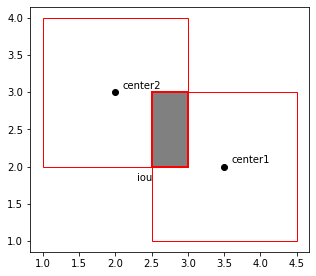

In [49]:
box1 = (3.5,2,2,2)
box2 = (2,3,2,2)
box_iou(box1,box2)

iou  =  0


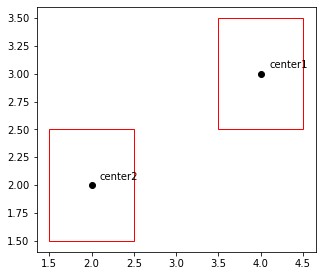

In [50]:
box1 = (4,3,1,1)
box2 = (2,2,1,1)
box_iou(box1,box2)

Here I start to implement the non-max suppression function

In [16]:
def NonMax_suppression(scores, boxes, classes, box_confidence, max_boxes = 10, iou_threshold = 0.5):
    """Applies Non-max suppression (NMS) to set of boxes
    
    Arguments:
    scores -- tensor of shape (None,), scores after first-round filtering 
    boxes -- tensor of shape (None, 4), boxes after first-round filtering 
    classes -- tensor of shape (None,), classes after first-round filtering
    max_boxes -- maximum number of predicted boxes
    iou_threshold -- "intersection over union" threshold used for NMS filtering
    
    Returns:
    scores -- tensor of shape (None, ), predicted score for each box
    boxes -- tensor of shape (None, 4), predicted box coordinates
    classes -- tensor of shape (None, ), predicted class for each box

    """
    # tensor to be used in tf.image.non_max_suppression()
    max_boxes_tensor = tf.Variable(max_boxes, dtype='int32')     

    # Use tf.image.non_max_suppression() to get the list of indices corresponding to boxes you keep
    nms_indices = tf.image.non_max_suppression(boxes,
                                               scores,
                                               max_boxes_tensor,
                                               iou_threshold = iou_threshold)
    
    # Use tf.gather() to select only nms_indices from scores, boxes and classes
    scores = tf.gather(scores, nms_indices)
    boxes = tf.gather(boxes, nms_indices)
    classes = tf.gather(classes, nms_indices)
    #return scores, boxes, classes
    
    box_confidence = tf.gather(box_confidence, nms_indices)
    return scores, boxes, classes, box_confidence
    

Using our simulation earlier (after first-round filtering), we can see the expected shape of outputs

In [17]:
scores, boxes, classes, box_confidence = NonMax_suppression(scores, boxes, classes, box_confidence, max_boxes = 10, iou_threshold = 0.5)

In [18]:
scores

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([53.283875, 46.53248 , 43.77442 , 42.906693, 42.41055 , 42.246723,
       41.86343 , 41.6903  , 41.126034, 40.659393], dtype=float32)>

In [19]:
classes

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([64, 35, 52, 32, 29, 73, 38, 22, 29, 17])>

In [20]:
boxes

<tf.Tensor: shape=(10, 4), dtype=float32, numpy=
array([[ -1.8525884 ,  -1.4687159 ,  -1.9092848 ,  -1.4973471 ],
       [  7.3993692 , -11.251137  ,  -1.7853963 ,  -1.0084369 ],
       [ -6.0772753 ,   0.89698327,  -0.11740685,  -1.6684694 ],
       [ -0.8198564 ,   4.3106055 ,  -0.6688293 ,   0.7852709 ],
       [  5.845234  ,   0.6844213 ,   6.0003467 ,   1.1340885 ],
       [  7.135264  ,   3.27236   ,   1.3557701 ,   9.026274  ],
       [  5.8722286 ,  -2.9096181 ,   5.5079684 ,   5.452997  ],
       [  1.3267213 ,  -1.7805707 ,  -2.6511786 ,   4.0587683 ],
       [ -7.692436  ,   2.2548542 ,   3.2853205 ,  -1.2728248 ],
       [ -0.95511186,   5.6637754 ,  -2.2418602 ,  -0.25960708]],
      dtype=float32)>

In [21]:
# this is a helper function from yolo original implementation to transform the represenataion of bounding boxes
def yolo_boxes_to_corners(box_xy, box_wh):
    """Convert YOLO box predictions to bounding box corners."""
    box_mins = box_xy - (box_wh / 2.)
    box_maxes = box_xy + (box_wh / 2.)

    return tf.keras.backend.concatenate([
        box_mins[..., 1:2],  # y_min
        box_mins[..., 0:1],  # x_min
        box_maxes[..., 1:2],  # y_max
        box_maxes[..., 0:1]  # x_max
    ])


In [22]:
from tensorflow.keras import backend as K
# this is also a helper function from yolo original implementation to rescale the boxes to match input images
def scale_boxes(boxes, image_shape):
    """ Scales the predicted boxes in order to be drawable on the image"""
    height = float(image_shape[0])
    width = float(image_shape[1])
    image_dims = K.stack([height, width, height, width])
    image_dims = K.reshape(image_dims, [1, 4])
    boxes = boxes * image_dims
    
    return boxes


In [23]:
# this is a wrapper function to convert the output of YOLO encoding to predicted boxes
def yolo_eval(yolo_outputs, image_shape = (720, 1280), max_boxes=10, score_threshold=.6, iou_threshold=.5, mode = 'default', min_confidence = 0.4):
    """
    Converts the output of YOLO encoding (a lot of boxes) to predicted boxes along with their scores, box coordinates and classes.
    
    Arguments:
    yolo_outputs -- output of the encoding model (for image_shape of (608, 608, 3)), contains 4 tensors:
                    box_xy: tensor of shape (None, 19, 19, 5, 2)
                    box_wh: tensor of shape (None, 19, 19, 5, 2)
                    box_confidence: tensor of shape (None, 19, 19, 5, 1)
                    box_class_probs: tensor of shape (None, 19, 19, 5, 80)
    image_shape -- tensor of shape (2,) containing the input shape, in this notebook we use (608., 608.) 
    max_boxes -- integer, maximum number of predicted boxes you'd like
    score_threshold -- real value, if [ highest class probability score < threshold], then get rid of the corresponding box
    iou_threshold -- real value, "intersection over union" threshold used for NMS filtering
    
    Returns:
    scores -- tensor of shape (None, ), predicted score for each box
    boxes -- tensor of shape (None, 4), predicted box coordinates
    classes -- tensor of shape (None,), predicted class for each box
    """
    
    # Retrieve outputs of the YOLO model 
    box_xy, box_wh, box_confidence, box_class_probs = yolo_outputs
   
    # Convert boxes to be ready for filtering functions (convert boxes box_xy and box_wh to corner coordinates)
    boxes = yolo_boxes_to_corners(box_xy, box_wh)

    # Score-filtering with a threshold of score_threshold
    if mode == 'default':
        scores, boxes, classes, box_confidence = yolo_filter_boxes(boxes, box_confidence, box_class_probs, threshold = score_threshold)
    
    if mode == 'improved':
        scores, boxes, classes, box_confidence = improved_yolo_filter_boxes(boxes, 
                                                            box_confidence, 
                                                            box_class_probs, 
                                                            threshold = score_threshold, 
                                                            min_confidence = min_confidence)

        
    # Scale boxes back to original image shape.
    boxes = scale_boxes(boxes, image_shape)
    
    # Non-max suppression with maximum number of boxes set to max_boxes and a threshold of iou_threshold 
    scores, boxes, classes, box_confidence =  NonMax_suppression(scores, boxes, classes, box_confidence, max_boxes, iou_threshold)

    return scores, boxes, classes, box_confidence


In [24]:
def predict(image_file, directory, mode = 'default'):
    """
    Runs the graph to predict boxes for "image_file". Prints and plots the predictions.
    
    Arguments:
    image_file -- name of an image stored in the directory folder.
    directory -- specify the path to find images. 
    
    Returns:
    out_scores -- tensor of shape (None, ), scores of the predicted boxes
    out_boxes -- tensor of shape (None, 4), coordinates of the predicted boxes
    out_classes -- tensor of shape (None, ), class index of the predicted boxes
    
    Note: "None" actually represents the number of predicted boxes, it varies between 0 and max_boxes. 
    """

    # Preprocess your image

    image, image_data = preprocess_image(directory+"/" + image_file, model_image_size = (608, 608))
    yolo_model_outputs = yolo_model(image_data)
    yolo_outputs = yolo_head(yolo_model_outputs, anchors, len(class_names))
    
    out_scores, out_boxes, out_classes, box_confidence = yolo_eval(yolo_outputs, [image.size[1],  image.size[0]], 10, 0.3, 0.5, mode = mode)

    # Print predictions info
    print('Found {} boxes for {}'.format(len(out_boxes), "images/" + image_file))
    # Generate colors for drawing bounding boxes.
    colors = get_colors_for_classes(len(class_names))
    # Draw bounding boxes on the image file
    draw_boxes(image, out_boxes, out_classes, class_names, box_confidence, out_scores)
    # Save the predicted bounding box on the image
    image.save(os.path.join("Example Detected Objects", image_file), quality=1000)
    # Display the results in the notebook
    output_image = Image.open(os.path.join("Example Detected Objects", image_file))
    imshow(output_image)
    plt.axis('off')

    return out_scores, out_boxes, out_classes

Found 3 boxes for images/person.jpg
horse 0.89 (399, 128) (605, 352) with object confidence:  0.8951488
person 0.81 (190, 98) (271, 379) with object confidence:  0.81154275
dog 0.79 (70, 258) (209, 356) with object confidence:  0.8427143


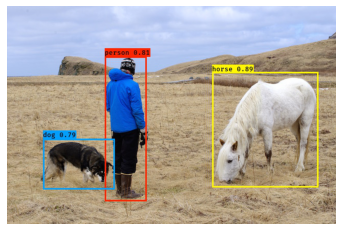

In [25]:
# example image from original folder
out_scores, out_boxes, out_classes = predict('person.jpg', directory = "yad2k/images")

Found 8 boxes for images/example_IDLE_group.jpg
person 0.84 (1112, 40) (1489, 1053) with object confidence:  0.83933645
person 0.78 (295, 376) (620, 1000) with object confidence:  0.7845086
person 0.77 (997, 167) (1225, 993) with object confidence:  0.78137636
person 0.72 (601, 366) (817, 912) with object confidence:  0.74279416
person 0.71 (779, 271) (1012, 895) with object confidence:  0.73758316
person 0.61 (85, 119) (322, 858) with object confidence:  0.61654496
----------------------------------------------------------------------------------------------------
person 0.36 (3, 105) (419, 1053) with object confidence:  0.35796142 
(will be discarded in improved mode; with minimum object confidence setting to be 0.4)
----------------------------------------------------------------------------------------------------
pottedplant 0.31 (269, 811) (602, 1053) with object confidence:  0.42516845


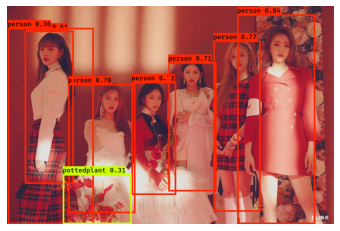

In [26]:
out_scores, out_boxes, out_classes = predict('example_IDLE_group.jpg', directory = "images")

Found 7 boxes for images/example_IDLE_group.jpg
person 0.84 (1112, 40) (1489, 1053) with object confidence:  0.83933645
person 0.78 (295, 376) (620, 1000) with object confidence:  0.7845086
person 0.77 (997, 167) (1225, 993) with object confidence:  0.78137636
person 0.72 (601, 366) (817, 912) with object confidence:  0.74279416
person 0.71 (779, 271) (1012, 895) with object confidence:  0.73758316
person 0.61 (85, 119) (322, 858) with object confidence:  0.61654496
pottedplant 0.31 (269, 811) (602, 1053) with object confidence:  0.42516845


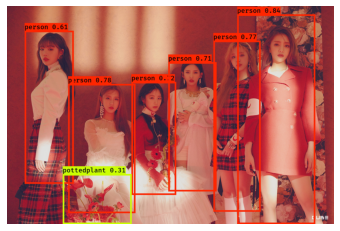

In [27]:
out_scores, out_boxes, out_classes = predict('example_IDLE_group.jpg', directory = "images", mode = 'improved')

Found 6 boxes for images/westwood1.jpeg
car 0.85 (2019, 1737) (3179, 2188) with object confidence:  0.8527074
person 0.83 (1026, 1692) (1144, 2115) with object confidence:  0.83199203
car 0.81 (3249, 1795) (4010, 2229) with object confidence:  0.8177346
car 0.71 (1219, 1755) (1990, 2098) with object confidence:  0.7886517
car 0.68 (558, 1766) (1044, 2035) with object confidence:  0.6875615
car 0.50 (229, 1744) (541, 1984) with object confidence:  0.62596667


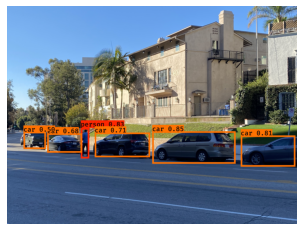

In [28]:
out_scores, out_boxes, out_classes = predict('westwood1.jpeg', directory = "images", mode = 'improved')

Found 6 boxes for images/westwood1.jpeg
car 0.85 (2019, 1737) (3179, 2188) with object confidence:  0.8527074
person 0.83 (1026, 1692) (1144, 2115) with object confidence:  0.83199203
car 0.81 (3249, 1795) (4010, 2229) with object confidence:  0.8177346
car 0.71 (1219, 1755) (1990, 2098) with object confidence:  0.7886517
car 0.68 (558, 1766) (1044, 2035) with object confidence:  0.6875615
car 0.50 (229, 1744) (541, 1984) with object confidence:  0.62596667


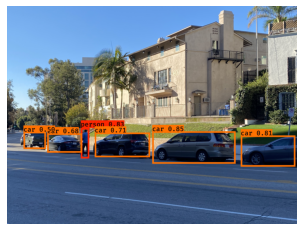

In [29]:
out_scores, out_boxes, out_classes = predict('westwood1.jpeg', directory = "images", mode = 'default')

In [30]:
# Import a module that contains helper functions to extract frames from a video, predict bounding boxes and convert back
# to output video
from video.video_operation.extract_and_combine import read_picture, write_video, ExtractVideoFrame

In [31]:
def video_with_prediction(input_folder , output_folder, mode = 'default'):
    '''
    Helper function to predict and draw bounding boxes in input image folder, then outputs to output folder
    
    Arguments:
    input_folder -- the folder containing input images 
    output_folder -- the folder containing input images with bounding boxes 
    mode -- 'default' to use original yolo_filter_boxes function; 'improved' to use the filter function with an additional filtering threshold on confidence
    
    Return:
    history -- dictionary containg dictionaries for each input image; it keeps a record of all output scores, 
    classes, boxes, number of boxes, and box confidence. 
    '''
    # choose input image path according to mode 
    input_path = 'video/Input Video by Frames/'+input_folder
    if mode == 'default':
        output_path = "video/Output Images/"+output_folder
    else: 
        output_path = "video/Output Images Improved/"+output_folder
    # extract all input images 
    file_list = os.listdir(input_path)
    file_list.sort()

    history = {}
    info = {}
    # predict draw bounding boxes on input images 
    for frame in file_list:
        
        image, image_data = preprocess_image(input_path+ "/" + frame, model_image_size = (608, 608))
        yolo_model_outputs = yolo_model(image_data)
        yolo_outputs = yolo_head(yolo_model_outputs, anchors, len(class_names))
        
        out_scores, out_boxes, out_classes, box_confidence = yolo_eval(yolo_outputs, [image.size[1],  image.size[0]], 10, 0.3, 0.5, mode = mode)

        colors = get_colors_for_classes(len(class_names))
        # Draw bounding boxes on the image file
        draw_boxes(image, out_boxes, out_classes, class_names, box_confidence, out_scores, verbose = 0)
        # Save the predicted bounding box on the image
        if not os.path.exists(output_path):
            os.mkdir(output_path)
        image.save(os.path.join(output_path, frame), quality=1000)
        
        # store info in a dictionary for every image, and add all to a single dictionary 
        info[frame[0:6]+'_out_scores'] = out_scores.numpy()
        info[frame[0:6]+'_out_classes'] = out_classes.numpy()
        info[frame[0:6]+'_out_boxes']  = out_boxes.numpy()
        info[frame[0:6]+'_box_nums'] = len(out_boxes)
        info[frame[0:6]+'_box_confidence'] = box_confidence.numpy()
        history[frame] = info

    return history 


In [36]:
def to_video(video_name, mode = 'default', fps = 3, verbose = 0):
    '''Create video in folder video/Output Videos/default or video/Output Videos/improved/ according to mode input value
    
    Arguments:
    video_name -- name of the video(specified for creating folders)
    mode -- 'default'
    fps -- target fps of exported video 
    verbose -- whether add more information to output dataframe
    
    Return:
    history -- dictionary containg dictionaries for each input image; it keeps a record of all output scores
    classes, boxes, number of boxes, and box confidence. 
    df -- a dataframe with the first column being filenames, and second column being number of boxes.
    '''
    
    history = video_with_prediction(video_name, video_name, mode = mode)
    
    # create video according to mode value
    if mode =='default':
        write_video(video_name, output_path = 'video/Output Videos/default/'+video_name, fps = fps)
        file_list = os.listdir('video/Output Images/'+video_name)
    else: 
        write_video(video_name, output_path = 'video/Output Videos/improved/'+video_name, fps = fps)
        file_list = os.listdir('video/Output Images Improved/'+video_name)
    file_list.sort()

    # extract information from dictionary and create a dataframe to store the needed information
    df = pd.DataFrame()
    df['filename'] = file_list
    df['box_nums'] = [history[i][i[0:6]+'_box_nums'] for i in file_list]
    
    if verbose != 0:
        df['scores'] = [history[i][i[0:6]+'_out_scores'] for i in file_list]
        df['box_confidence'] = [history1[i][i[0:6]+'_box_confidence'] for i in file_list]

    return history, df



In [41]:
# extract frames 
video_input = 'video/horses.mp4'
output_path = 'video/Input Video by Frames/horses'

frame_frequency = 1

ExtractVideoFrame(video_input, output_path, frame_frequency, verbose = 0)

Start video/horses.mp4
!!! END !!!


In [42]:

history_horse_default, df_horse_default = to_video('horses', fps = 30)
history_horse_improved, df_horse_improved= to_video('horses', mode = 'improved', fps = 30)

In [61]:
len(df_horse_default['filename'])

262

This means the horse video is splitted into 262 frames. 

In [59]:
((df_horse_default['box_nums'] - df_horse_improved['box_nums'])>1).sum()

25

There are 25 frames where the improved algorithm predict less bounding boxes than the default. Note that the maximum number of boxes is predefined to be 10, and it can be changed. 

In [62]:
max(df_horse_default['box_nums'] - df_horse_improved['box_nums'])

3

The maximum difference in number of predicted bounding boxes is 3

In [73]:
index = df_horse_default['box_nums'] - df_horse_improved['box_nums'] == 3
df_horse_default[index]

,filename,box_nums
143,000143.jpg,9
215,000215.jpg,8
230,000230.jpg,10


In [71]:
df_horse_improved[index]

,filename,box_nums
143,000143.jpg,6
215,000215.jpg,5
230,000230.jpg,7


We can see that there are three images in which our two algorithms predict differently. In the plot blow I show the first frame 000143.jpg. 

<img align="left" src="video/Output Images Improved/horses/000143.jpg" style="width:400px;height:200;" ><img  src="video/Output Images/horses/000143.jpg" style="width:400px;height:200;">
　　　　　　　　　　　　Improved　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　Default 

It can be seen that there are 7 horses in total. The default algorithnm draws 9 boxes, while the improved version draws 6 boxes. Taking a closer look, the problem is indeed overlapping boxes predicting a single object. And in this example, we can see that the improved algorithm indeed increases the recall rate and reduced repeated prediction.

In [51]:
video_input = 'video/westwood1.mp4'
output_path = 'video/Input Video by Frames/westwood1'

frame_frequency = 1

ExtractVideoFrame(video_input, output_path, frame_frequency, verbose = 0)

Start video/westwood1.mp4
!!! END !!!


In [52]:
history_westwood_default, df_westwood_default = to_video('westwood1', fps = 30)
history_westwood_improved, df_westwood_improved= to_video('westwood1', mode = 'improved', fps = 30)

In [74]:
len(df_westwood_default['filename'])

326

There are 326 frames in total in the short video near UCLA shot by myself.

In [76]:
((df_westwood_default['box_nums'] - df_westwood_improved['box_nums'])>1).sum()

107

In [77]:
max(df_westwood_default['box_nums'] - df_westwood_improved['box_nums'])

4

The maximum difference in number of predicted bounding boxes is 4

In [86]:
index = df_westwood_default['box_nums'] - df_westwood_improved['box_nums'] == 3
index = np.random.choice(df_westwood_default[index].index,1)
df_westwood_default.iloc[index,:]

,filename,box_nums
290,000290.jpg,10


<img align="left" src="video/Output Images Improved/westwood1/000290.jpg" style="width:200px;height:100;" ><img  src="video/Output Images/westwood1/000290.jpg" style="width:200px;height:100;">
　　　　　　　　　　　　Improved　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　　Default 

As we can see in the images, there are a lot of overlapping cars, which make it difficult for the algorithm to distinguish. The improved version filters out some cars that are far away and appears to be small. So possiblly this is a drawback of implementing an additional filtering threshold on box confidence.